# 모델 파인튜닝 실습

### 개,고양이 데이터셋 줄이기

In [6]:
# 개고양이 작은 데이터셋 만들기
import os, shutil

original_dataset_dir = './CatsAndDogs/train/'

base_dir = './CatsAndDogs/data'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Create directories
train_dir = os.path.join(base_dir,'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir,'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir,'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir,'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir,'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir,'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')     
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(100)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(200, 250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(250,300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(100)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
                                                
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(200,250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(250,300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)
                                                
# Sanity checks
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 100
total training dog images: 100
total validation cat images: 50
total validation dog images: 50
total test cat images: 50
total test dog images: 50


### VGG16네트워크 가져오기
- Weights : 이미지넷으로 트레이닝된 모델 가져오기
- include_top : 최상위에 fc레이어를 포함할지 안할지 결정(fully connected)
- input_tensor : 이미지 텐서의 크기

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Activation, Dropout,Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

In [6]:
conv_base = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3)))

In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

 - ImageDataGenerator를 사용하여 이미지와 레이블을 넘파이 배열로 추출

 - conv_base모델의 predict 메서드를 호출하여 이 이미지에서 특성을 추출

### 특성 추출 함수

In [9]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './CatsAndDogs/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


In [12]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))  # convolution base ouutput과 일치해야함
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150,150),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # convolutional base를 거친 데이터를 가져온다.
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break  ## 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로
                   ## 모든 이미지를 한 번씩 처리하고 나면 중지해야함
    return features, labels

In [13]:
train_features, train_labels = extract_features(train_dir, 200)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, 100)
test_features, test_labels = extract_features(test_dir, 100)

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### 정의하고 훈련

In [117]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(4,4,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(4*4*512)))
#model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

# Compile model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 8192)              0         
                                                                 
 dense_31 (Dense)            (None, 256)               2097408   
                                                                 
 dense_32 (Dense)            (None, 1)                 257       
                                                                 
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
100/100 [==============================] - 1s 6ms/step - loss: 0.2579 - acc: 0.9055 - val_loss: 0.3826 - val_acc: 0.8400
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.4363 - val_acc: 0.8300
Epoch 3/100
100/100 [====================

In [ ]:
def accuracy_visual(history):
    

    accs = history.history['acc']
    val_accs = history.history['val_acc']

    plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
    plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(range(len(accs)),loss, label = 'Training_loss')
    plt.plot(range(len(accs)),val_loss, label = 'Validation_loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

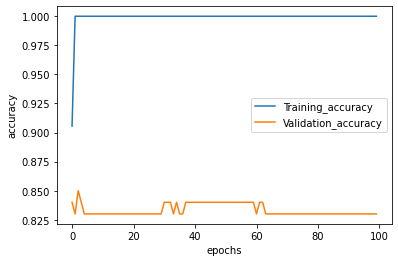

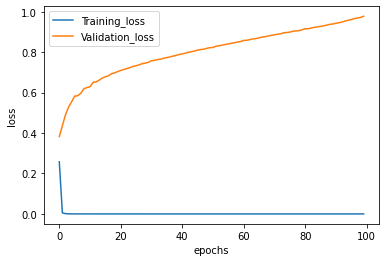

In [121]:
accuracy_visual(history)

- 의문점 vgg16모델을 가져올때 include_top 값을 true로 해주는것과 input_dim 을 설정해주는것이 같은것 아닌가?
- 과적합이 되고 학습이 전혀 되지않는 모습을 볼수 있다.


### Global average pooling, 평균 풀링
- 앞서 실행해본 모델과 다른 점은, convolutional base에서 추출된 특징을 완전연결계층에 넣는 대신, 평균 풀링 계층에 넣은 후 시그모이드 활성화 함수에 넣는 것
ㅤ

- 소프트맥스 함수 대신 시그모이드 함수를 사용 Lin et al. (2013) 논문에서 제안된 방법.
- Keras에서 카테고리가 두개인 분류(이진분류)를 하기 위해서는 활성화 함수로 시그모이드 함수를, 손실함수로는 이진 크로스엔트로피 (binary_crossentropy)를 사용해야 합니다 (Chollet 2017). 

In [122]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.GlobalAveragePooling2D(input_shape=(4,4,512)))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

# Compile model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_33 (Dense)            (None, 1)                 513       
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: 0.6626 - acc: 0.6150 - val_loss: 0.5747 - val_acc: 0.7900
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 0.5336 - acc: 0.8210 - val_loss: 0.4984 - val_acc: 0.8200
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 0.4591 - acc: 0.8620 - val_loss: 0.4592 - va

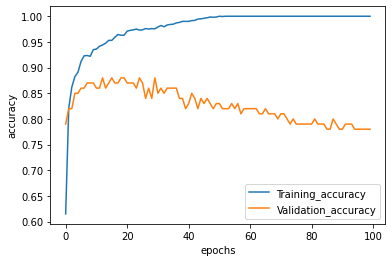

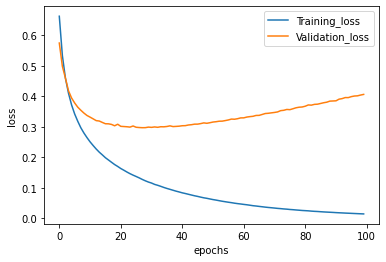

In [123]:
accuracy_visual(history)

- 훨씬 개선된 결과를 보여준다

### Linear support vector machines, 선형 서포트 벡터 머신
- 선형 서포트 벡터 머신 학습
ㅤ

- 이번 모델은 머신러닝 모델이므로, 학습을 위해서 머신러닝의 전통적인 방법 사용하겠습니다. K-fold cross-validation 방법을 이용해서 모델을 평가할 것입니다. 따라서 훈련 데이터셋과 검증 데이터셋을 하나로 합쳐서 사용하겠습니다. 테스트 데이터는 여전히 분리시켜 놓습니다!

In [77]:
# Concatenate training and validation sets
svm_features = np.concatenate((train_features, validation_features))
svm_labels = np.concatenate((train_labels, validation_labels))

- 여기서 잠깐, 우리는 SVM 모델은 단 하나의 파라미터만 갖는다는 사실을 기억합시다! 바로 에러율에 대한 규제 파라미터 C입니다. 이 파라미터를 최적화하기 위해서, 그리드 서치(Grid-Search) 방법을 사용하겠습니다. [code 6]은 모델 생성에 대한 코드를, [그림 9]는 학습 과정을 보여줍니다.

In [99]:
# Build model
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

X_train, y_train = svm_features.reshape(-1,4*4*512), svm_labels

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]
 
C_list = [0.01, 0.1, 1, 10, 100]

svm = LinearSVC(penalty='l2', loss='squared_hinge')  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10)
clf.fit(X_train, y_train)




c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\pc\appdata\local\programs\python\python

GridSearchCV(cv=10, estimator=LinearSVC(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}])

In [109]:
X_test, y_test = test_features.reshape(-1,4*4*512), test_labels
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
from sklearn.metrics import accuracy_score

print("train정확도:" , accuracy_score(y_train, pred_train))
print("test:" , accuracy_score(y_test, pred_test))

train정확도: 1.0
test: 0.85


In [112]:

train_acc_list = []
test_acc_list = []
for C in C_list:
    svc = SVC(kernel='linear', C=C)
    svc.fit(X_train, y_train)

    train_acc_list.append(accuracy_score(y_train, svc.predict(X_train)))
    test_acc_list.append(accuracy_score(y_test, svc.predict(X_test)))

import pandas as pd
d = dict(C=C_list,
        train_정확도=train_acc_list,
        test_정확도=test_acc_list)

df = pd.DataFrame(d)
df

,C,train_정확도,test_정확도
0,0.01,1.0,0.85
1,0.10,1.0,0.85
2,1.00,1.0,0.85
3,10.00,1.0,0.85
4,100.00,1.0,0.85


In [96]:
print(history.best_score_) 
print(history.best_params_)


1.0
{'C': 0.01}


- 결과는 C값만 놓고보면 차이가없다.
- 모델이과적합
- 85프로 validation 정확도라 개선